<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

Чтобы не умирал колаб

function ClickConnect(){
console.log("Working"); 
 document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect,60000)


Вот этот код попробуй вставить в консоль вкладки (ctrl+shift+I)

И вроде не должен отключаться

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1RpAjKLktZKIgVQjfpQRDQKDE4L5MsIV4 #64
!gdown --id 1FcJ4d66dic7wF_R4oLYKoDHQKldzxbNU #256
!gdown --id 14Y0pv9oex8EmrhCOBXrMrx2OswjzoIsI #512
!unzip -q faces64c.zip && rm faces64c.zip
!unzip -q faces256c.zip && rm faces256c.zip
!unzip -q faces512c.zip && rm faces512c.zip
#___________________________________________________________
!gdown https://drive.google.com/uc?id=1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9  #faces_dataset_small.zip
!unzip faces_dataset_small.zip -d data/
!rm -r data/__MACOSX/ data/faces_dataset_small/04000 data/faces_dataset_small/.DS_Store

In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
import gc
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import pylab as pl
from IPython.display import clear_output
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [4]:
os.getcwd()

'/content'

In [5]:
!ls -l

total 4183224
drwxr-xr-x 3 root root       4096 Jun 21 15:09 data
drwx------ 5 root root       4096 Jun 21 15:04 drive
drwxrwxr-x 3 root root       4096 Jun  6 07:35 faces256c
drwxrwxr-x 3 root root       4096 Jun  5 12:00 faces512c
drwxrwxr-x 3 root root       4096 Jun  5 11:54 faces64c
-rw-r--r-- 1 root root 4283591562 Jun 21 15:07 faces_dataset_small.zip
drwxr-xr-x 1 root root       4096 Jun 15 13:37 sample_data


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [6]:
def get_dataloader(image_size, batch_size):
    """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
    """
    DATA_DIR = os.getcwd()+'/faces512c'#'\\datasets\\gan\\faces_dataset_small'
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
                                                           tt.Resize(image_size),
                                                           tt.ToTensor()]))
    return DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [7]:
image_size = 128
batch_size = 64
train_dl_ = get_dataloader(image_size, batch_size)

In [8]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        
        show_images(images, nmax)
        break

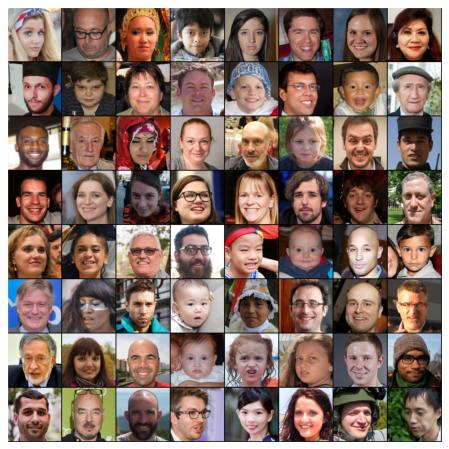

In [ ]:
show_batch(train_dl_)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [11]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __count__(self):
        """Number of elements in dataset"""
        return len(self.dl.dataset)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
latent_size = 512

In [14]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [15]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [16]:
train_dl = DeviceDataLoader(train_dl_, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
def show_images_while_training(generated, n_images, num_rows=4):
  fig, ax = plt.subplots(figsize=(12, 12))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(generated.detach()[:n_images], nrow=num_rows).permute(1, 2, 0))

In [ ]:
def fit(model, criterion, optimizer, train_dl, epochs, lr, latent_size, batch_size, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):

            optimizer["discriminator"].zero_grad()
            real_preds = model["discriminator"](real_images)
            r1, r2 = 0.7, 1.2
            real_targets = (r1 - r2) * torch.rand(real_images.size(0), 1, device=device) + r2
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            r1, r2 = 0.0, 0.3
            fake_targets = (r1 - r2) * torch.rand(fake_images.size(0), 1, device=device) + r2
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()
            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            optimizer["generator"].zero_grad()
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            preds = model["discriminator"](fake_images)
            r1, r2 = 0.7, 1.2
            targets = (r1 - r2) * torch.rand(batch_size, 1, device=device) + r2
            loss_g = criterion["generator"](preds, targets)
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        clear_output(wait=True)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        random_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        generated_imgs = model["generator"](random_latent)
        show_images_while_training(generated_imgs.cpu(), 16, 8)

        display.display(pl.gcf())
        if epoch == epochs - 1:
          fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
          save_samples(epoch+start_idx, fixed_latent, show=False)

          torch.save({
              'G_state_dict': model['generator'].state_dict(),
              'G_optimizer_state_dict': optimizer['generator'].state_dict(),
              'G_loss': loss_g,
              }, '/content/drive/MyDrive/Generator-{}'.format(start_idx + epoch)) 
          
          torch.save({
              'D_state_dict': model['discriminator'].state_dict(),
              'D_optimizer_state_dict': optimizer['discriminator'].state_dict(),
              'D_loss': loss_d,
              }, '/content/drive/MyDrive/Discriminator-{}'.format(start_idx + epoch)) 
    
    return losses_g, losses_d, real_scores, fake_scores

In [17]:
lr = 3e-4
epochs = 300

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": torch.nn.BCELoss(),
    "generator": torch.nn.BCELoss()
}
optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                      lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(),
                                  lr=lr, betas=(0.5, 0.999))
}

In [ ]:
history = fit(model, criterion, optimizer, train_dl, epochs, lr, latent_size, batch_size)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-0{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

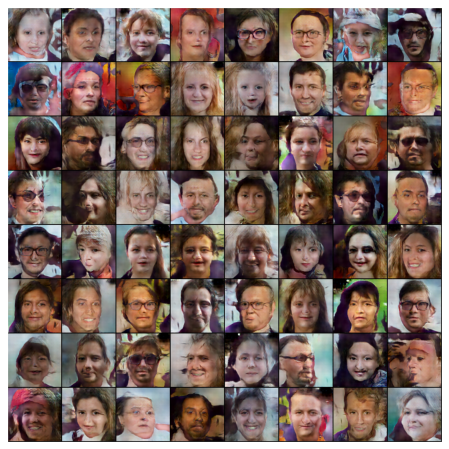

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

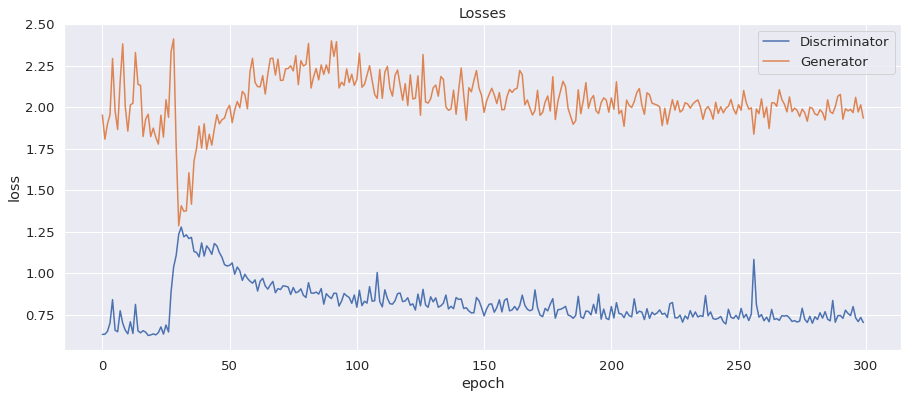

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

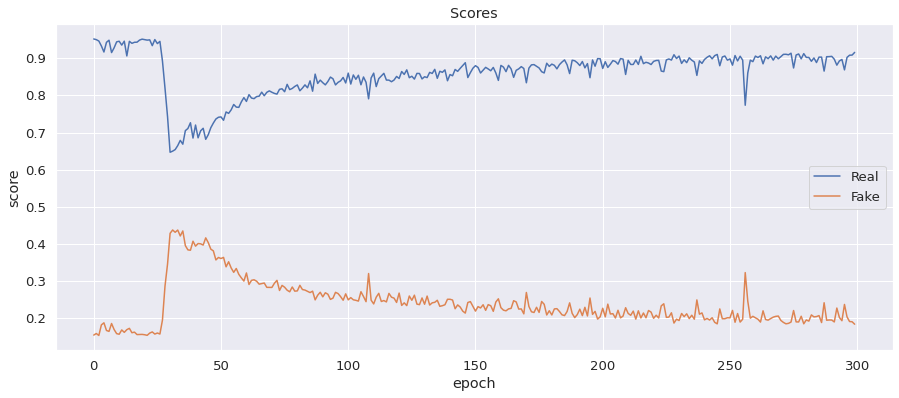

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Явного доменантного поведения не обнаружено, то что нам и нужно.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=torch.device('cuda'))
fake_images = model["generator"](fixed_latent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


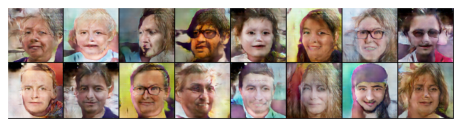

In [ ]:
show_images(fake_images.cpu())

Как вам качество получившихся изображений?

Качество для неглубокой сети хорошее. Были испробовано многое из [1](https://github.com/soumith/ganhacks), [2](https://github.com/openai/improved-gan/blob/master/imagenet/discriminator.py), [3](https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/), Wasserstein GAN, обучение 500 эпох, RAdam. Зашли нечеткие метки. К сожалению не успел исследовать pixleshuffle.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [18]:
optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

In [21]:
G_checkpoint = torch.load("/content/drive/MyDrive/GAN/g") 
model['generator'].load_state_dict(G_checkpoint['G_state_dict'])
optimizer['generator'].load_state_dict(G_checkpoint['G_optimizer_state_dict'])

In [22]:
D_checkpoint = torch.load("/content/drive/MyDrive/GAN/d") 
model['discriminator'].load_state_dict(D_checkpoint['D_state_dict'])
optimizer['discriminator'].load_state_dict(D_checkpoint['D_optimizer_state_dict'])

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_score

In [ ]:
def calculate_accuracy(model, latent_size=512, image_size=128, n_images=150):
  train_loader_new = get_dataloader(image_size, n_images)
  true_preds = 0
  count_of_images = 0

  for real_images,_ in tqdm(train_loader_new):
    num_of_images = len(real_images)
    fixed_latent = torch.randn(num_of_images, latent_size, 1, 1, device=device) 
    with torch.no_grad():
      fake_images = model["generator"](fixed_latent)

    X = np.concatenate([np.asarray([fake_images.cpu()[i].flatten().numpy() for i in range(fake_images.shape[0])]), 
                        np.asarray([img.cpu().flatten().numpy() for img in real_images])])
    del fake_images, real_images
    gc.collect()
    
    X -= X.mean(axis = 0)
    X = PCA(X.shape[0]).fit_transform(X)
    y = np.concatenate([np.zeros(num_of_images), np.ones(num_of_images)]).astype('int32')

    LOO = LeaveOneOut()

    for train_index, test_index in LOO.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]  
      OneNearestClassifier = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
      y_pred = OneNearestClassifier.predict(X_test)
      if y_test == y_pred: true_preds += 1
    count_of_images += num_of_images*2
  accuracy = true_preds/count_of_images
  print('Accuracy is ', accuracy)

  return accuracy

In [ ]:
acc = calculate_accuracy(model)


Accuracy is  0.6205854279350939


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Мы хотели получить accuracy == 0.5. Это бы означало что классификатор не может отличить настоящие и не настоящие картинки. Полученое значение 0.62 Показывает что модель получилась не идеальной, но близкой к искомому.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [24]:
from sklearn.manifold import TSNE
import seaborn as sns

In [31]:
def visualize_distribution(model, latent_size=512, image_size=128, n_images=100):

  train_loader_new = get_dataloader(image_size, n_images)

  true_preds = 0
  count_of_images = 0

  fig, ax = plt.subplots(figsize=(9, 9))

  for real_images,_ in train_loader_new:
    num_of_images = len(real_images)
    
    fixed_latent = torch.randn(num_of_images, latent_size, 1, 1, device=device) 
    with torch.no_grad():
      fake_images = model["generator"](fixed_latent)

    X = np.concatenate([np.asarray([fake_images.cpu()[i].flatten().numpy() for i in range(fake_images.shape[0])]), 
                        np.asarray([img.cpu().flatten().numpy() for img in real_images])])
    del fake_images, real_images
    gc.collect()

    y = np.concatenate([np.zeros(num_of_images), np.ones(num_of_images)]).astype('int32')
    X_embedded = TSNE(n_components=2).fit_transform(X)

    display.clear_output(wait=True)
    sns.jointplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, legend='brief')
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, legend='brief')
    plt.legend(['Fake', 'Real'])
  # display.display(pl.gcf())

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1598: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


CPU times: user 4min 35s, sys: 26.6 s, total: 5min 2s
Wall time: 5min 3s


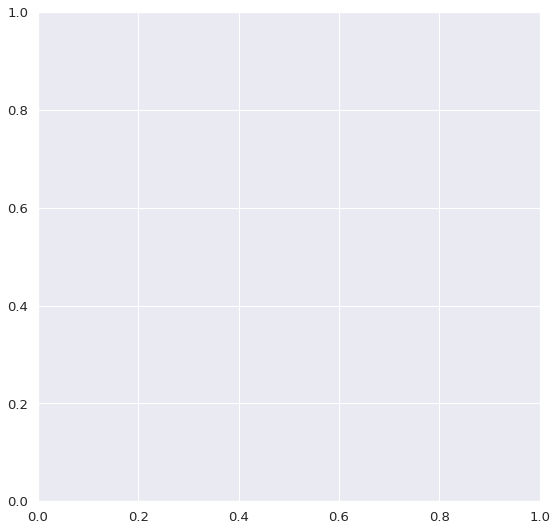

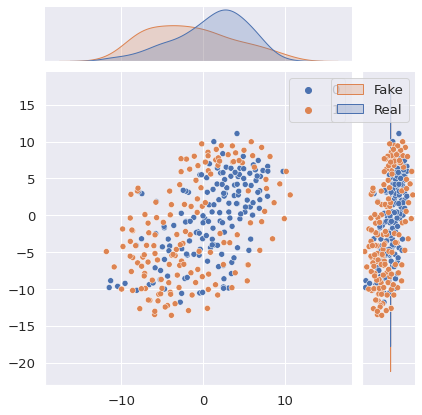

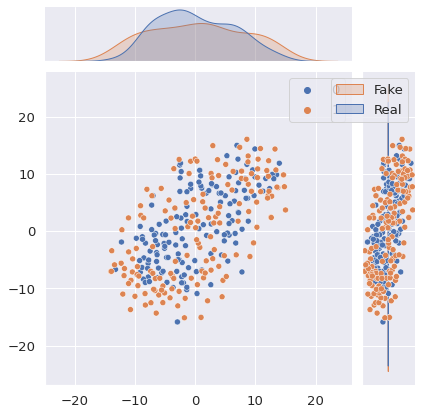

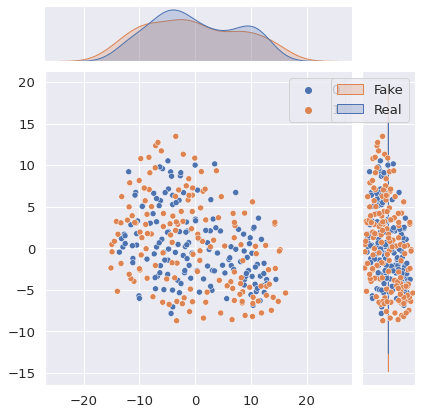

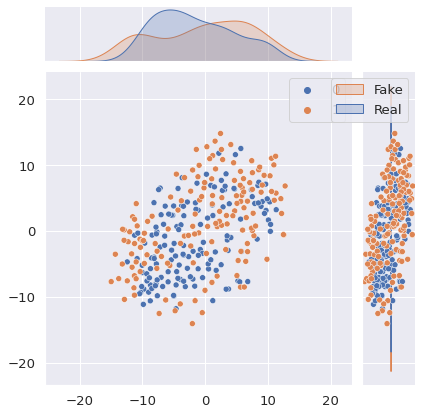

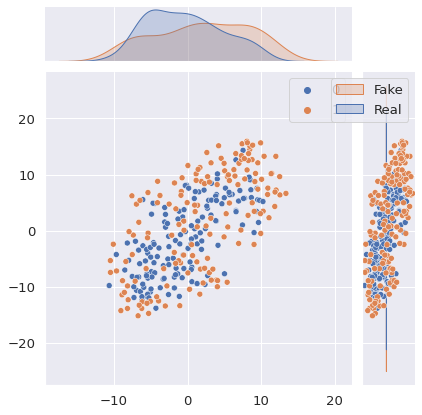

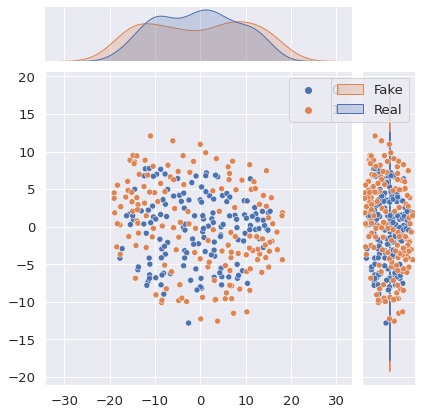

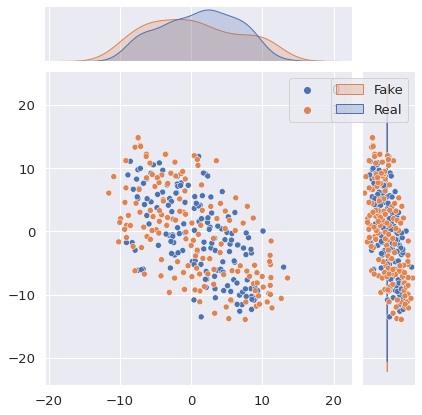

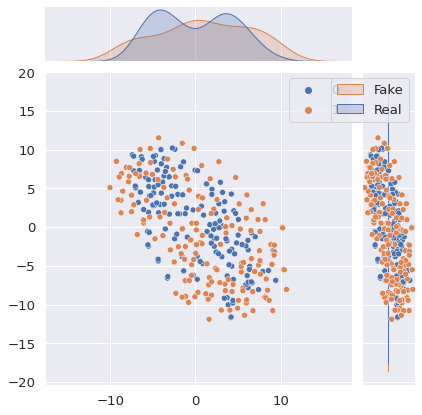

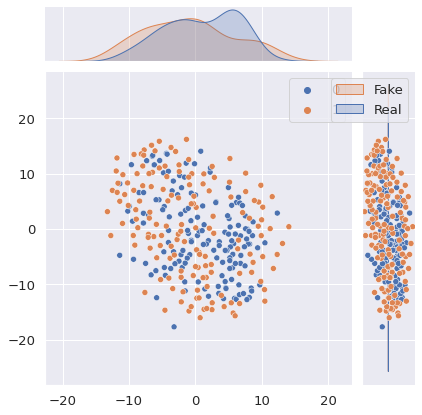

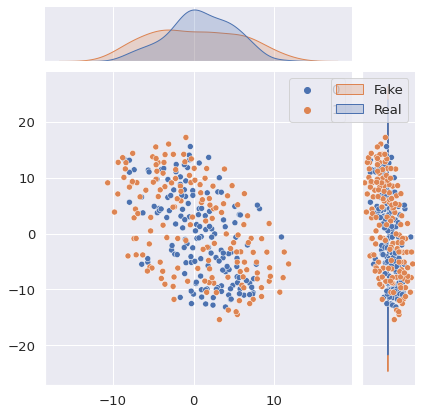

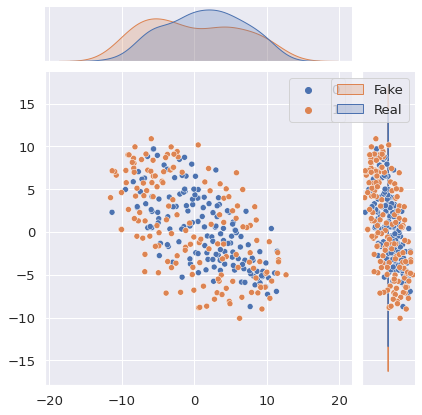

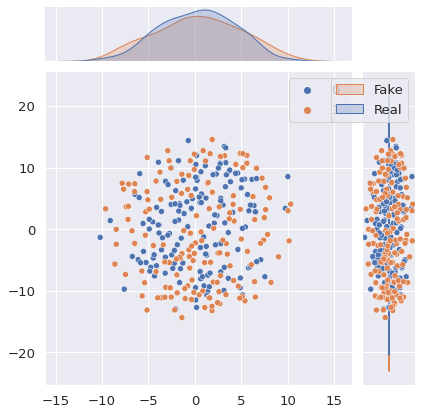

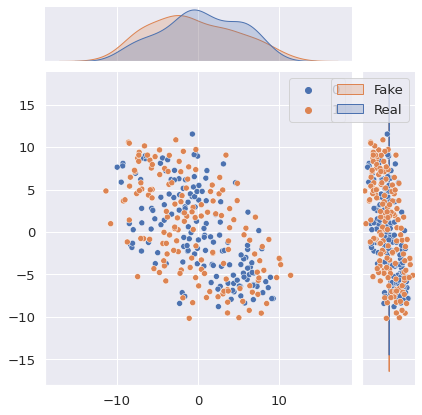

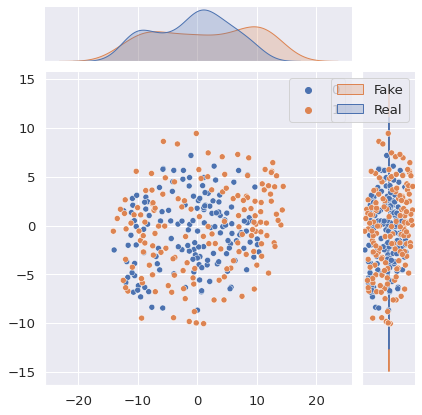

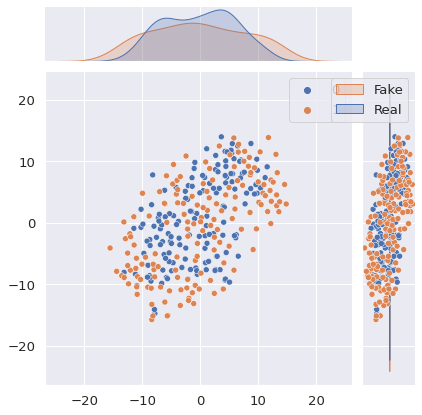

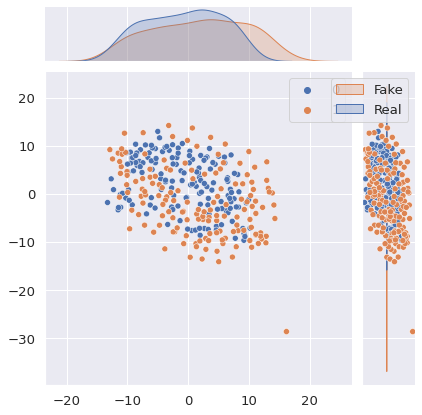

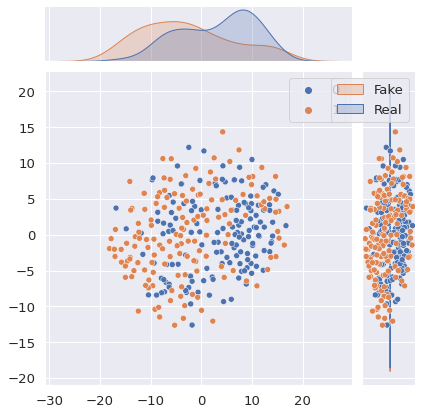

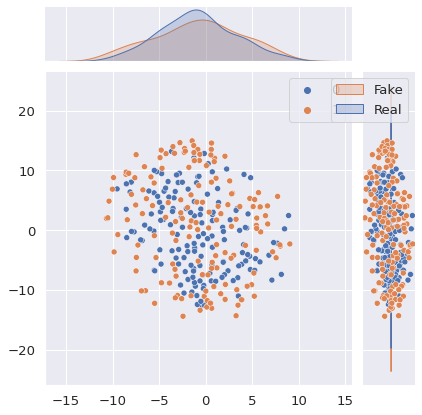

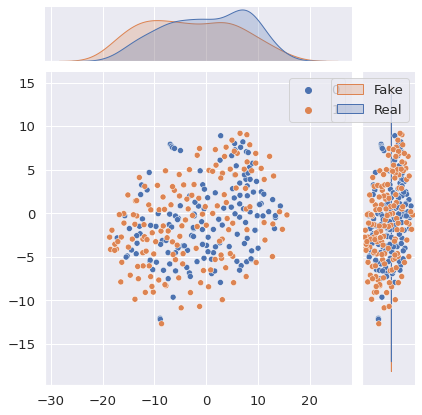

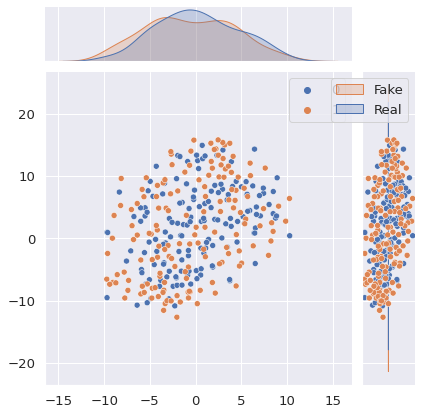

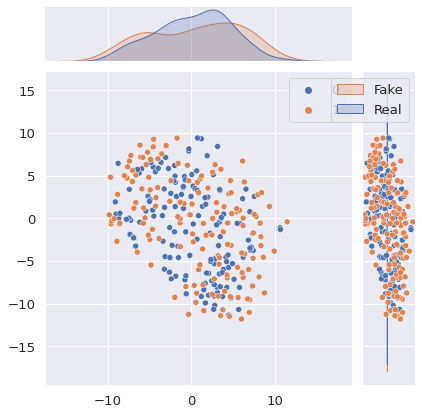

In [32]:
%%time
visualize_distribution(model, image_size=128, n_images=150)

Прокомментируйте получившийся результат:

В двумерном пространстве точки, распределены схоже-равномерно, нет четко разделения. Скорее всего подгон распределения фейковых под настоящие дало такой хороший результат.